# Model odwróconego wahadła na wózku i jego optymalne sterowanie przy pomocy regulatora liniowo-kwadratowego

## *Maciej Manna*

Poniższy projekt prezentuje fizyczny model odwróconego wahadła umieszczonego na wózku przemieszczającym się poziomo w jednym wymiarze.
Jest to model istotnie nieliniowy. Ponadto poruszone zostaną zagadnienia związane z jego sterowaniem, pozwalającym wywierać siłę na wózek w poziomie.
Poruszone zostaną następujące zagadnienia:
    
- fizyczny model odwróconego wahadła, jego symulacja i wizualizacja rezultatów;
- linearyzacja modelu i zagadnienie jego sterowalności;
- przykładowe sterowania dopuszczalne danego układu i ich zachowanie;
- wyznaczanie optymalnego sterowania przy pomocy regulatora liniowo-kwadratowego (LQR).

Opisany przykład zainspirowany został i w dużej mierzę oparty na rozważaniach książce Bruntona i Kutza ([1], s. 300-305).
Szczególy wyprowadzenia LQR zostały zaczerpnięte z wykładów Evansa ([2], s. 81-83).

In [ ]:
%matplotlib inline

import math
import numpy as np
from scipy.integrate import solve_ivp
from numpy.linalg import matrix_rank
from scipy.linalg import eigvals
import matplotlib.pyplot as plt
from visualise import simple_plot, phase_plots #, sim_animation
from control import ctrb, lqr
from control.matlab import place

## Model odwróconego wahadła na wózku

![Model odwróconego wachadła na wózku z zaznaczeniem wybranych wolnych zmiennych i parametrów. Żródło: [1], s.301](img/model.png)

Powyższa ilustracja przedstawia sytuację fizyczną, którą modelujemy wraz z wybranymi wolnymi zmiennymi i parametrami ([1], s.301). Nasz model ma cztery **stopnie swobody** (wolne zmienne):

- $x$ - pozycja wózka na poziomej osi;
- $v = \dot{x}$ - prędkość wózka na poziomej osi;
- $\theta$ - odchylenie (kąt) sztywnego ramienia wahadła względem osi pionowej;
- $\omega = \dot{\theta}$ - prędkość kątowa ramienia wahadła zaczepionego w środku masy wózka.

Symbolem $Y$ oznaczać będziemy pełny wektor stanu naszego systemu, tj. $Y = [ x \; v \; \theta \; \omega ]$. Odpowiednio: $\dot{Y} = [ \dot{x} \; \dot{v} \; \dot{\theta} \; \dot{\omega} ]$

Ponadto nasz układ charakteryzuje pięć fizycznych parametrów, które pozostają stałe w czasie. Są to (wraz z domyślnymi wartościami, które używane będą w dalszych przykładach; używamy wartości niemianowanych, ale zakłądamy stosowne jednostki układu SI):

- $M$ - masa wóźka ($M = 5$);
- $m$ - masa wahadła, skupiona w punkcie na jego końcu ($m = 1$);
- $L$ - długość wahadła ($L = 2$);
- $g$ - przyśpieszenie grawitacyjne ($g = -10$);
- $\delta$ - współczynnik tłumienia (tarcie, opór powietrza, etc.) związany z wózkiem ($\delta = 1$).

Co więcej, jednym z parametrów układu jest $u = F$, a więc siłą wywierana na wózek, aby wywołać zmianę jego prędkości. Będzie to nasz parametr sterowania. Póki co zakładamy $u = 0$.


In [ ]:
def get_params(*, M=5.0, m=1.0, L=2.0, g=-10.0,d=1.0, b=1.0):
    return (M, m, L, g, d, b)

Nieliniową dynamikę naszego systemu można wyprowadzić z podstawowych zasad dynamiki. Poniżej zaprezentowane są **równania opisujące ewolucję układu** wg [1] (8.67a-d, s. 300-301):

$$
\begin{cases}
\frac{dx}{dt} = v \\
\frac{dv}{dt} = \frac{1}{D} \left[ -m^2 L^2 g \cos \theta \sin \theta + m L^2 (m L \omega^2 \sin \theta - \delta v ) + m L^2 u) \right] \\
\frac{d\theta}{dt} = \omega \\
\frac{d\omega}{dt} = \frac{1}{D} \left[ (m + M)mgL \sin \theta - mL \cos \theta (mL \omega^2 \sin \theta - \delta v) - mL \cos \theta u \right]
\end{cases}
\, ,
$$
gdzie powtarza się jednakowy mianownik $D = m L^2 (M + m ( 1 - \cos^2 \theta ) )$.


Nasz układ posiada dwa **punkty stałe**, do których możemy dążyć jako potencjalne **cele sterowania** - jest to stan, w którym wahadło ustawione jest pionowo w górę lub w dół, nie obraca się oraz sam wózek się nie przemieszcza. Formalnie, wymagamy, aby $v = \omega = 0$ oraz $\theta = 0$ lub $theta = \pi$. Taki stan (cel) nie zależy od położenia wóżka, które moze być dowolne ($x \in \mathbb{R}$).  

In [ ]:
def get_dynamics(params, u=0):
    M, m, L, g, d, _ = params
    
    def inv_pend(t, Y):
        sinth = math.sin(Y[2])
        costh = math.cos(Y[2])
        D = m * L * L * (M + m * (1 - (costh * costh)))
    
        dY = np.array([
            Y[1], # dx
            (1./D) * (-(m * m * L * L * g * costh * sinth) + (m * L * L * (m * L * Y[3] * Y[3] * sinth - d * Y[1]) ) ) + (m * L * L * (1./D) * u), # dv
            Y[3], # dtheta
            (1./D) * (((m + M) * m * g * L * sinth) - (m * L * costh * (m * L * Y[3] * Y[3] * sinth - d * Y[1]))) - (m * L * costh * (1./D) * u) # domega
        ])
        return dY
    return inv_pend

### Rozwiązywanie układu i wizualizacja wyników

Poniżej rozwiazujemy numerycznie układ nieliniowych równań różniczkowych opisujących model dla pewnego **przedziału czasu**: $[t_0, t_1]$ oraz pewną rozdzielczością kroków czasowych $\Delta t$. Domyślnie zakładamy: $t_0 = 0, t_1 = 20, \Delta t = 0.1$.

Ponadto musimy przyjąć pewne **warunki początkowe** dla naszego układu: $Y_0 = [ x_0 \; v_0 \; \theta_0 \; \omega_0 ]$. Domyślnie zakładamy: $Y_0 = [ 0 \; 0 \; \pi \; 0.5 ]$.

In [ ]:
def get_timespan(*, t0 = 0.0, t1 = 20.0, dt = 0.1):
    return [t0, t1], np.arange(t0, t1 + dt, dt)

def get_init_cond(*, x0 = 0.0, v0 = 0.0, th0 = math.pi, w0 = 0.5):
    return np.array([x0, v0, th0, w0])

In [ ]:
# całkowanie układu równań reprezentującego dynamikę systemu

par = get_params()
Y0 = get_init_cond()
ts, teval = get_timespan()
dyn = get_dynamics(par)

res = solve_ivp(dyn, ts, Y0, t_eval=teval)

In [ ]:
# wizualizacja - proste wykresy zmiennych stanu od czasu
simple_plot(res.t, res.y)

In [ ]:
# wizualizacja - projekcje przestrzeni fazowej na płaszczyzny odpowiadające zmiennym wózka i wahadła
phase_plots(res.y)

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML

In [ ]:
def sim_animation(Y, params, stride = 1):
    L = params[2]
    
    fig, ax = plt.subplots(figsize=(15, 10))

    plt.grid()
    plt.xlabel('x')

    ax.set_xlim(( -5, 5))
    ax.set_ylim(( - L, L + 1))

    p1, = plt.plot([],[])
    p2, = plt.plot([],[], c='#000000')
    p3 = plt.scatter([],[],s=10,c='#55ff00',marker='s')
    p4 = plt.scatter([],[],s=3,c='#000000',marker='o')
  

    plots = [p1, p2, p3, p4]
    
    def init():
        p1.set_data([-15, 15], [0, 0])
        p3.set_sizes([10000])
        p4.set_sizes([2000])
        return plots

    def animate(frame):
        cart_x = Y[0, frame * stride]
        cart_y = 0.5
        head_x = cart_x + L * math.sin(math.pi - Y[2, frame * stride])
        head_y = cart_y + L * math.cos(math.pi - Y[2, frame * stride])

        p2.set_data([cart_x, head_x], [cart_y, head_y])
        p3.set_offsets([[cart_x, cart_y]])
        p4.set_offsets([[head_x, head_y]])

        return plots

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=Y.shape[1] // stride, interval=20, blit=True)
    HTML(anim.to_html5_video())
    rc('animation', html='html5')
    
    return anim


In [ ]:
sim_animation(res.y, par)

## Linearyzacja układu i jego sterowalność

Prosta obserwacja równań reprezentujących ewolucję naszego układu pozwala wywnioskować, że są one dość zawikłane i nieliniowe. Aby rozważać uproszczony model sterowania dla modeli liniowych stosujemy ich **linearyzację**. Linearyzację dokonujemy wokół dwóch wcześniej wspomnianych punktów stałych. Co ciekawę, okazuje się, że dwie potencjalne linearyzacje (wahadło pionowo w górę lub w dół) różnią się jedyie znakiem przy niektórych wyrażeniach. W związku z tym wprowadzamy nowy parametr $b = \pm 1$, który pozwala rozróżnić te dwa potencjalne sterowania. W dalszych rozważaniach szukać będziemy sterowań prowadzących do wahadła stojącego do góry, zatem przyjmujemy $b = 1$.

Nasz układ w zlinearyzowanej formie przyjmuje postać:

$$ \frac{dY}{dt} = \mathbf{A} Y + \mathbf{B} u \; , $$

gdzie:

$
\mathbf{A} = 
\begin{bmatrix}
0 &                     1 &                    0 & 0 \\
0 &    - \frac{\delta}{M} &        \frac{bmg}{M} & 0 \\
0 &                     0 &                    0 & 1 \\
0 & - \frac{b \delta}{ML} & - \frac{b(m+M)g}{ML} & 0
\end{bmatrix}
\quad \text{oraz} \quad
\mathbf{B} = 
\begin{bmatrix}
           0 \\
 \frac{1}{M} \\
           0 \\
\frac{b}{ML}
\end{bmatrix}
\; .
$

In [11]:
def get_linear(params):
    M, m, L, g, d, b = params
    A = np.array([[0.0, 1.0, 0.0, 0.0],
                  [0.0, - d / M, b * m * g / M, 0.0],
                  [0.0, 0.0, 0.0, 1.0],
                  [0.0, -b * d / (M * L), -b * (m + M) * g / (M * L), 0.0]])
    B = np.array([[0.0], [1.0 / M], [0.0], [b / (M * L)]])
    return A, B
    
A, B = get_linear(get_params())
print(A)
print(B)

[[ 0.   1.   0.   0. ]
 [ 0.  -0.2 -2.   0. ]
 [ 0.   0.   0.   1. ]
 [ 0.  -0.1  6.   0. ]]
[[0. ]
 [0.2]
 [0. ]
 [0.1]]


### Stabilność układu

Z wykresów zmiennych stanu otrzymanych powyżej widać, że układ bez zewnętrznego sterowania zachowuje się chaotycznie i nie wydaje się dążyć do stanu stabilnego. Potwierdza to analiza wartości własnych macierzy układu zlinearyzowanego (patrz niżej), wśród których występuje wartość dodatnia.

In [12]:
eigs = eigvals(A)
print(eigs)

[ 0.        +0.j -2.431123  +0.j -0.23363938+0.j  2.46476238+0.j]


### Sterowalność układu

Zanim zaczniemy rozważać dopuszczalne i optymalne sterowania naszego układu musimy zbadać jego sterowalność. Ponieważ dysponujemy już zlinearyzowaną formą naszego układu, możemy obliczyć macierz sterowalności i sprawdzić czy jej rząd jest równy wymiarowi układu (tu: $4$). Poniższe obliczenia wskazują, że nasz układ jest sterowalny.

In [13]:
ctrb_mx = ctrb(A, B)
ctrb_rk = matrix_rank(ctrb_mx)
if ctrb_rk == 4:
    print("Układ jest sterowalny.")
else:
    print("Układ nie jest sterowalny.")

Układ jest sterowalny.


## Przykładowe sterowania stabilizujące układ

Wiemy, że nasz układ jest sterowalny. Oznacza to, że istnieje takie $u = -\mathbf{K}Y$, że rozważając układ:
$$ \frac{dY}{dt} = (\mathbf{A} - \mathbf{BK})Y \;$$
możemy znaleźć taką jego macierz (tj. $\mathbf{A} - \mathbf{BK}$), że wszystkie jej wartości własne są niedodatnie.

W szczególności dysponujemy funkcją ```place(A, B, eigs)```, która pozwala nam dla danych macierzy $\mathbf{A}$ i $\mathbf{B}$ oraz dowolnych, rządanych wartości własnych (```eigs```) otrzymać odpowiednią macierz $\mathbf{K}$.

Przykłady sterowań, coraz bardziej agresywnych (bardziej ujemne wartości własne), przedstawione są poniżej.

In [14]:
# alternatywna funkcja zwracająca dynamikę układu, pozwalające otrzymać układ ze sterowaniem prowadzącym do macierzy układu z podanymi wartościami własnymi

def get_dynamics_for_eigs(params, ctrl_eigs):
    M, m, L, g, d, b = params
    A, B = get_linear(params)
    K = place(A, B, ctrl_eigs)
        
    def inv_pend(t, Y):
        sinth = math.sin(Y[2])
        costh = math.cos(Y[2])
        D = m * L * L * (M + m * (1 - (costh * costh)))
        Y_ref = np.array([1.0, 0.0, (b + 1.0) * 0.5 * math.pi, 0.0]) # pozycja referencyjna (tj. cel; x = 1)
        u = - np.dot(K, Y - Y_ref)
    
        dY = np.array([
            Y[1], # dx
            (1./D) * (-(m * m * L * L * g * costh * sinth) + (m * L * L * (m * L * Y[3] * Y[3] * sinth - d * Y[1]) ) ) + (m * L * L * (1./D) * u), # dv
            Y[3], # dtheta
            (1./D) * (((m + M) * m * g * L * sinth) - (m * L * costh * (m * L * Y[3] * Y[3] * sinth - d * Y[1]))) - (m * L * costh * (1./D) * u) # domega
        ])
        return dY
    return K, inv_pend

<ipython-input-14-0c1e24bc02c6>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  dY = np.array([


[[-1.71428468e-07 -1.00003571e+00  6.00350003e+01  1.00007135e+00]]


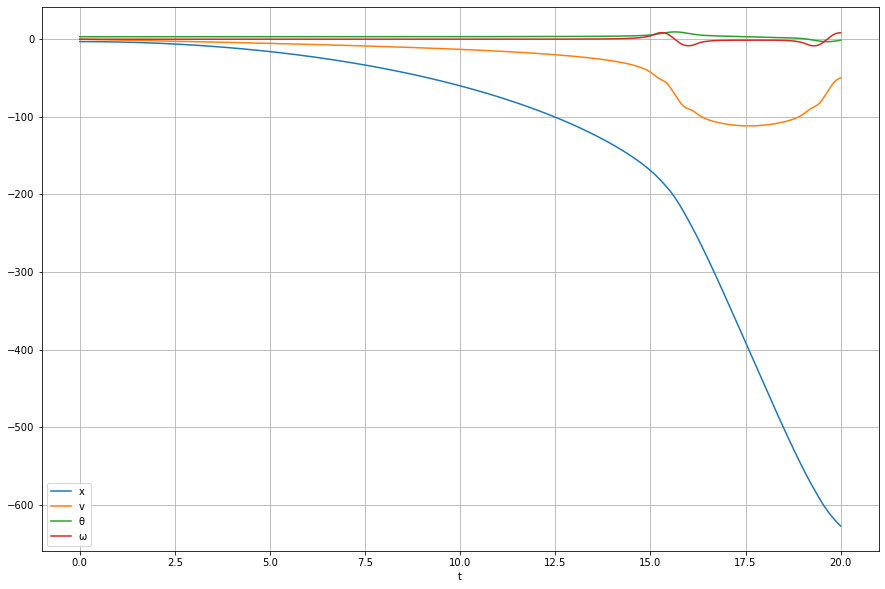

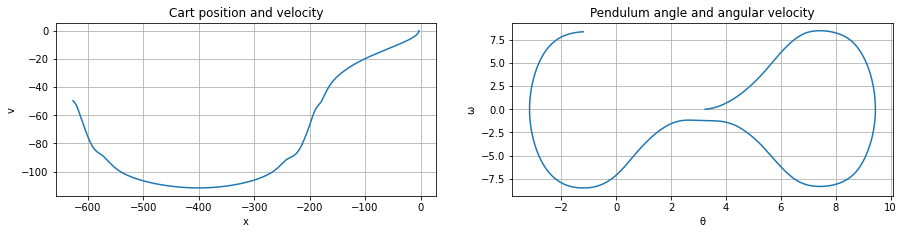

In [15]:
Y0_eigs = get_init_cond(x0=-3.0, v0 = 0.0, th0=math.pi+0.1, w0=0.0)
ts_eigs, t_eval_eigs = get_timespan(dt=0.001)

eig1 = np.array([-0.01, -0.02, -0.03, -0.04])
K1, dyn1 = get_dynamics_for_eigs(par, eig1)
res1 = solve_ivp(dyn1, ts_eigs, Y0_eigs, t_eval=t_eval_eigs)

print(K1)

simple_plot(res1.t, res1.y)
phase_plots(res1.y)

In [ ]:
sim_animation(res1.y, par, stride=100)

<ipython-input-14-0c1e24bc02c6>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  dY = np.array([


[[-2.57142857e-02 -1.24428571e+00  7.19514286e+01  1.84885714e+01]]


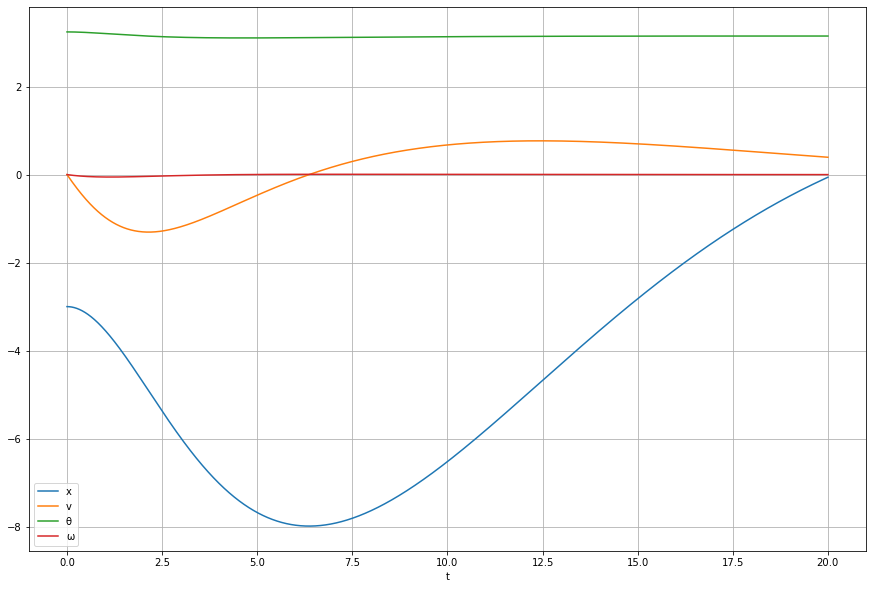

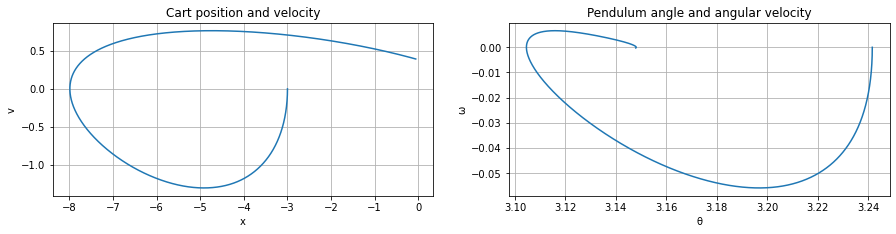

In [16]:
eig2 = np.array([-0.3, -0.4, -0.5, -0.6])
K2, dyn2 = get_dynamics_for_eigs(par, eig2)
res2 = solve_ivp(dyn2, ts_eigs, Y0_eigs, t_eval=t_eval_eigs)

print(K2)

simple_plot(res2.t, res2.y)
phase_plots(res2.y)

In [ ]:
sim_animation(res2.y, par, stride=50)

<ipython-input-14-0c1e24bc02c6>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  dY = np.array([


[[ -1.22571429  -5.30428571 141.55142857  54.60857143]]


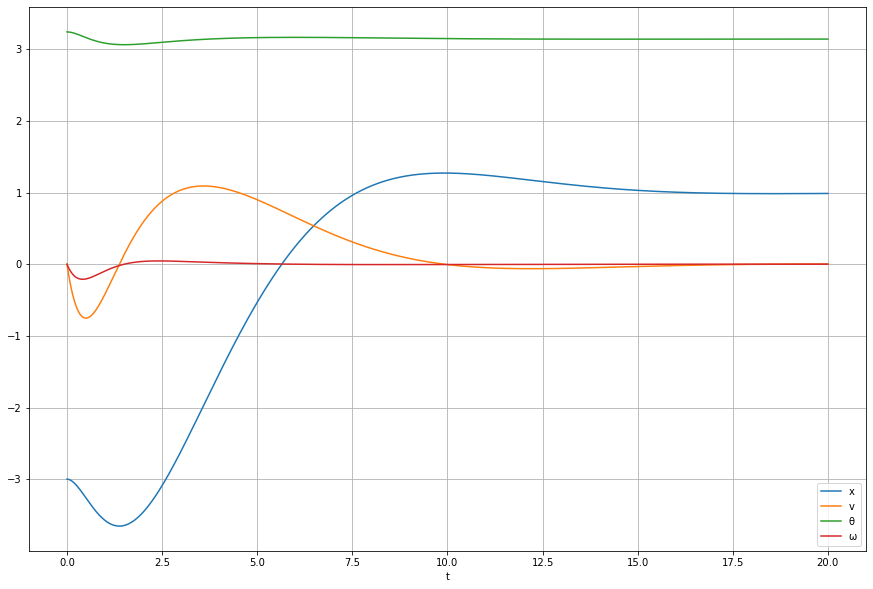

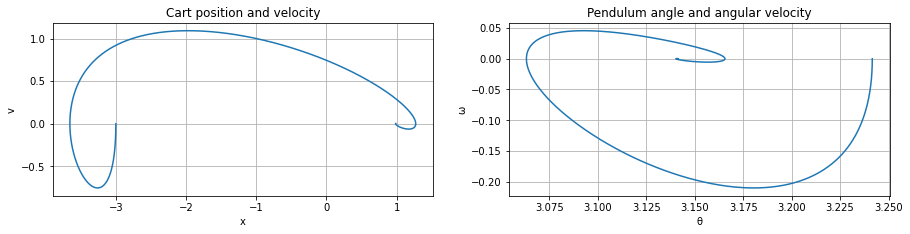

In [17]:
eig3 = np.array([-1.0, -1.1, -1.2, -1.3])
K3, dyn3 = get_dynamics_for_eigs(par, eig3)
res3 = solve_ivp(dyn3, ts_eigs, Y0_eigs, t_eval=t_eval_eigs)

print(K3)

simple_plot(res3.t, res3.y)
phase_plots(res3.y)

In [ ]:
sim_animation(res3.y, par, stride=50)

<ipython-input-14-0c1e24bc02c6>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  dY = np.array([


[[-15.18       -29.31857143 367.46       142.63714286]]


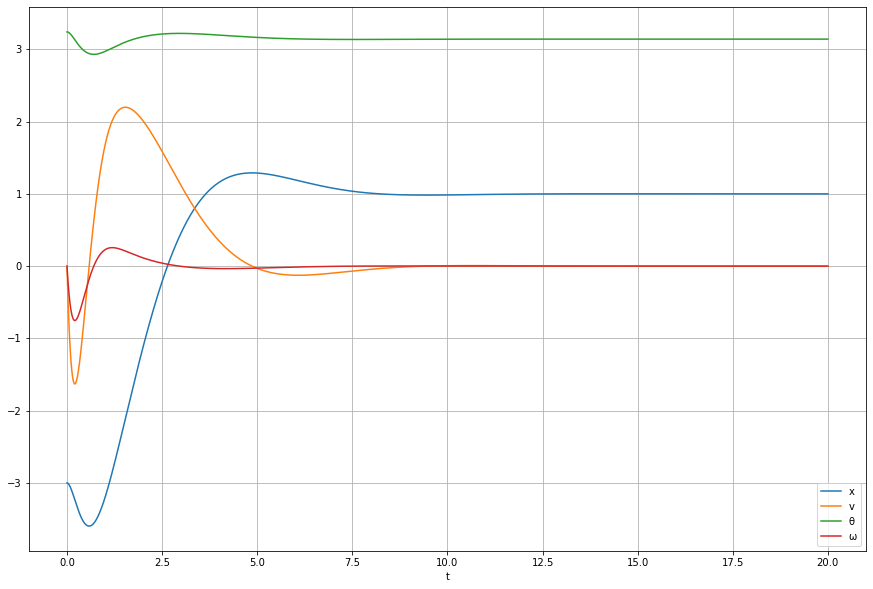

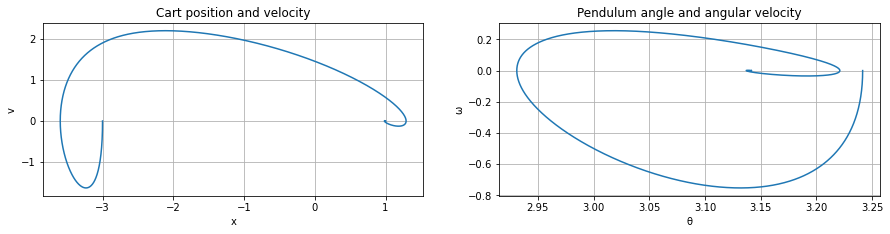

In [18]:
eig4 = np.array([-2.0, -2.1, -2.2, -2.3])
K4, dyn4 = get_dynamics_for_eigs(par, eig4)
res4 = solve_ivp(dyn4, ts_eigs, Y0_eigs, t_eval=t_eval_eigs)

print(K4)

simple_plot(res4.t, res4.y)
phase_plots(res4.y)

In [ ]:
sim_animation(res4.y, par, stride=50)

<ipython-input-14-0c1e24bc02c6>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  dY = np.array([


[[-70.14857143 -90.19       795.39714287 304.38000001]]


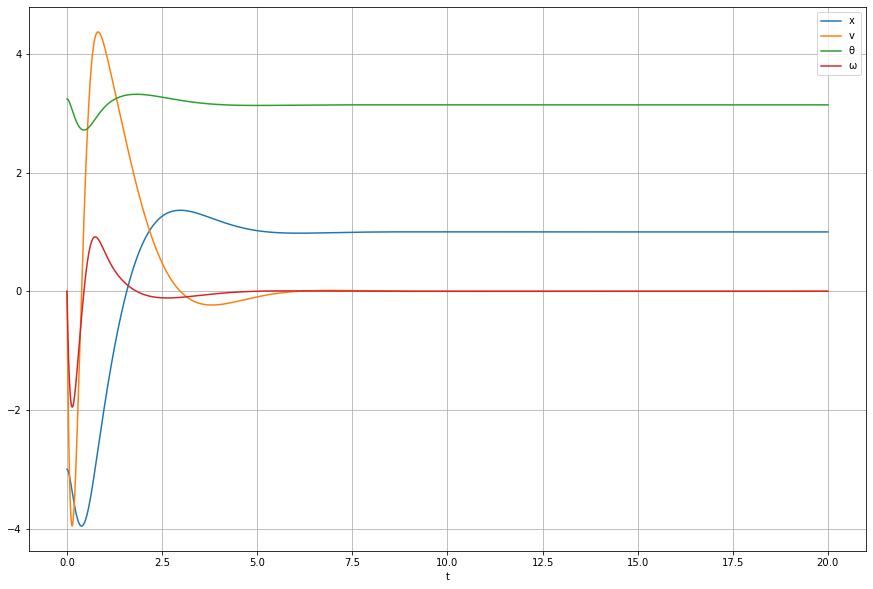

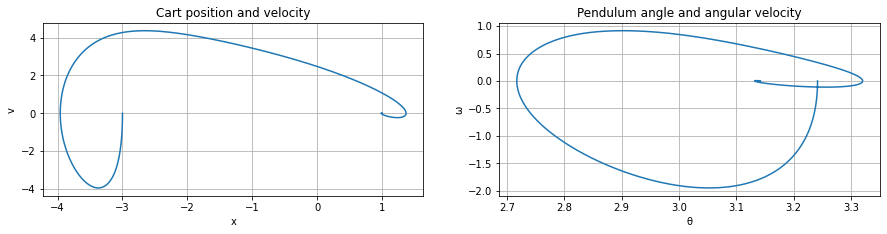

In [19]:
eig5 = np.array([-3.0, -3.1, -3.2, -3.3])
K5, dyn5 = get_dynamics_for_eigs(par, eig5)
res5 = solve_ivp(dyn5, ts_eigs, Y0_eigs, t_eval=t_eval_eigs)

print(K5)

simple_plot(res5.t, res5.y)
phase_plots(res5.y)

In [ ]:
sim_animation(res5.y, par, stride=50)

<ipython-input-14-0c1e24bc02c6>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  dY = np.array([


[[-126.54       -139.80428571 1112.17999998  423.60857142]]


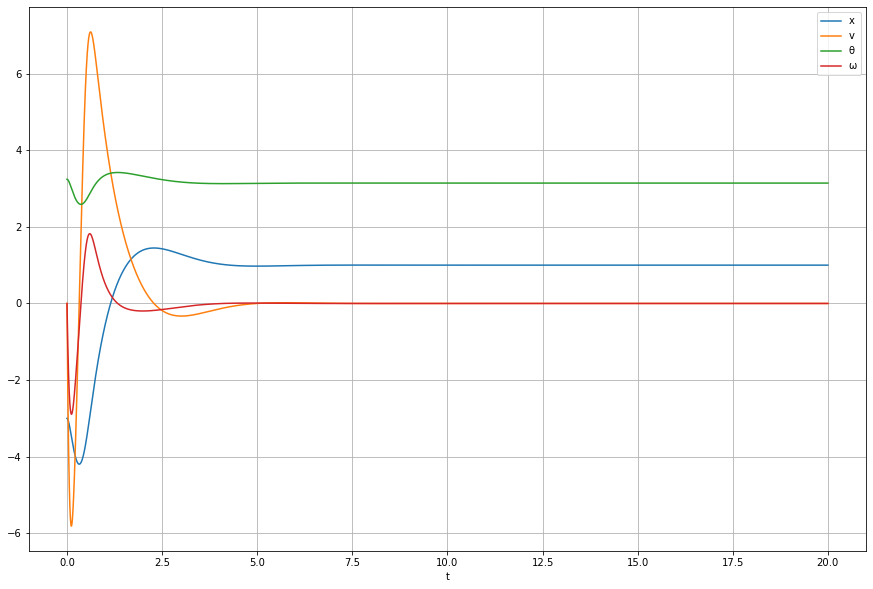

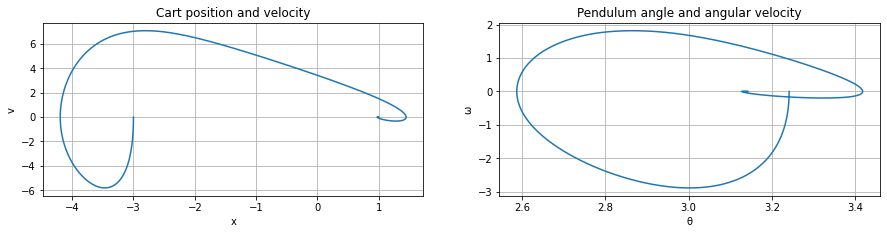

In [20]:
eig6 = np.array([-3.5, -3.6, -3.7, -3.8])
K6, dyn6 = get_dynamics_for_eigs(par, eig6)
res6 = solve_ivp(dyn6, ts_eigs, Y0_eigs, t_eval=t_eval_eigs)

print(K6)

simple_plot(res6.t, res6.y)
phase_plots(res6.y)

In [ ]:
sim_animation(res6.y, par, stride=50)

In [ ]:
# UKŁAD NIESTABILNY

#eig7 = np.array([-5.0, -5.1, -5.2, -5.3])
#K7, dyn7 = get_dynamics_for_eigs(par, eig7)
#res7 = solve_ivp(dyn7, ts_eigs, Y0_eigs, t_eval=t_eval_eigs)

#print(K7)

#simple_plot(res7.t, res7.y)
#phase_plots(res7.y)

## 4. Sterowanie optymalne

Otwarte pozostaje pytanie jak odnaleźć sterowanie optymalne (tj. odpowiednią macierz $\mathbf{K}$), zależnie od wyznaczonych kosztów i ich wzajemnych priorytetów - tj. oczekiwania jak najszybszej stabilizacji układu lub zużycia jak najmniejszej energii do sterowania. 

Do wyznaczenia takiego sterowania - w przypadku układu liniowego (tu: zliearyzowane) i kosztów określonych formami kwardatowego - posłużyć może **regulator liniowo-kwadratowy (LQR)**.

Szczegóły postaci LQR i jego wyprowadzenie zostało przedstawione na wcześniejszych ćwiczeniach. Przypomnijmy, że optymalność naszego rozwiązania musimy wyznaczyć względem pewnej funkcji kosztu. W naszym przypadku ma ona postać:

$$ \mathcal{J}(u) = \int_0^{\infty} \left( Y^T \mathbb{Q} Y + u^T R u \right) dt \; . $$

Tutaj $u \in \mathbb{R}$, zatem $R \in \mathbb{R}$, czyli jest po prostu skalarem. Ten parametr oznacza koszt związany ze zwiększaniem (na wartość bezwzględną) mocy sterowania, np. koszt energii/paliwa wykorzystywanych do poruszania wózka. Macierz $\mathbb{Q} \in \mathbb{R}^{4 \times 4}$, symetryczna, określa jak bardzo zwracana jest uwaga na rozbieżnośc danych zmiennych stanu od ich wartości docelowych.

In [21]:
# alternatywna funkcja zwracająca dynamikę układu ze sterowaniem optymalnym LQR
def get_dynamics_for_lqr(params, Q_lqr=None, R_lqr=0.0001):
    M, m, L, g, d, b = params
    A, B = get_linear(params)
    if Q_lqr is None:
        Q_lqr = np.eye(4)
    K, _, eigs = lqr(A, B, Q_lqr, R_lqr)
    
    def inv_pend(t, Y):
        sinth = math.sin(Y[2])
        costh = math.cos(Y[2])
        D = m * L * L * (M + m * (1 - (costh * costh)))
        Y_ref = np.array([1.0, 0.0, (b + 1.0) * 0.5 * math.pi, 0.0]) # pozycja referencyjna (tj. cel; x = 1)
        u = - np.dot(K, Y - Y_ref)
    
        dY = np.array([
            Y[1], # dx
            (1./D) * (-(m * m * L * L * g * costh * sinth) + (m * L * L * (m * L * Y[3] * Y[3] * sinth - d * Y[1]) ) ) + (m * L * L * (1./D) * u), # dv
            Y[3], # dtheta
            (1./D) * (((m + M) * m * g * L * sinth) - (m * L * costh * (m * L * Y[3] * Y[3] * sinth - d * Y[1]))) - (m * L * costh * (1./D) * u) # domega
        ])
        return dY
    return K, eigs, inv_pend

<ipython-input-21-81ee17e44dd7>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  dY = np.array([


[[-100.         -183.17927427 1683.18015821  646.61304924]]
[-22.357645 +0.j          -1.0008147+0.j          -2.4334955+0.57865554j
  -2.4334955-0.57865554j]


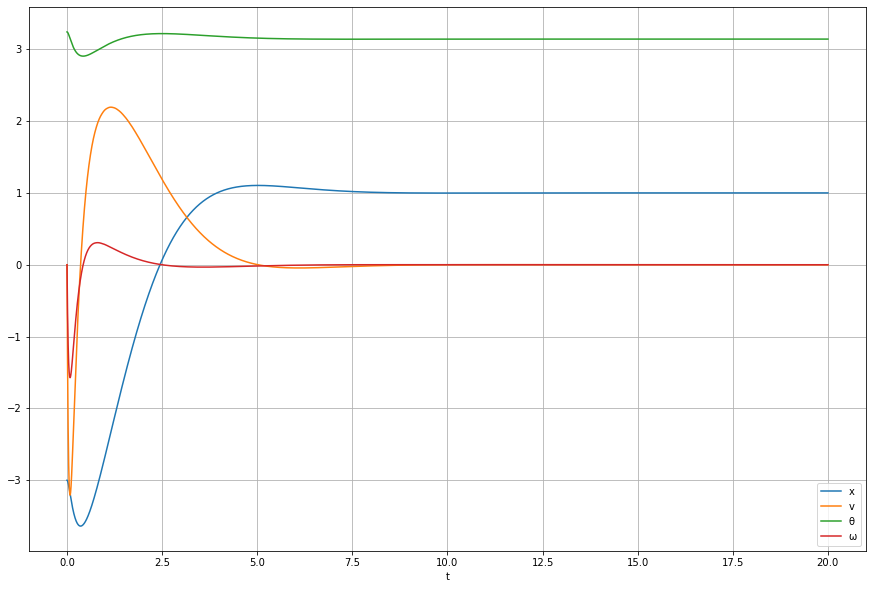

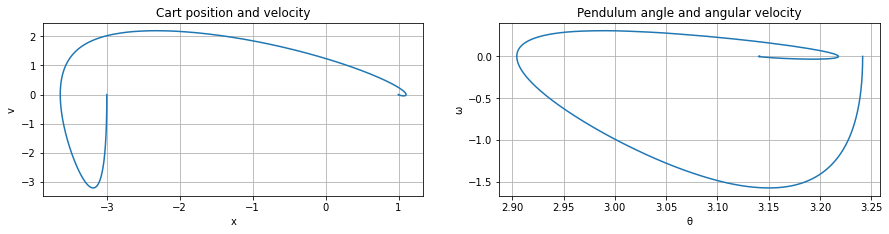

In [22]:
ts_lqr, t_eval_lqr = get_timespan(dt=0.001)

K_lqr, eigs_lqr, dyn_lqr = get_dynamics_for_lqr(par)
res_lqr = solve_ivp(dyn_lqr, ts_lqr, Y0_eigs, t_eval=t_eval_lqr)

print(K_lqr)
print(eigs_lqr)

simple_plot(res_lqr.t, res_lqr.y)
phase_plots(res_lqr.y)

In [ ]:
sim_animation(res_lqr.y, par, stride=50)

<ipython-input-21-81ee17e44dd7>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  dY = np.array([


[[ -31.6227766   -73.58924546 1004.80602597  495.65703441]]
[-32.4244    +0.j          -0.8751928 +0.89327043j
  -0.8751928 -0.89327043j  -0.87306917+0.j        ]


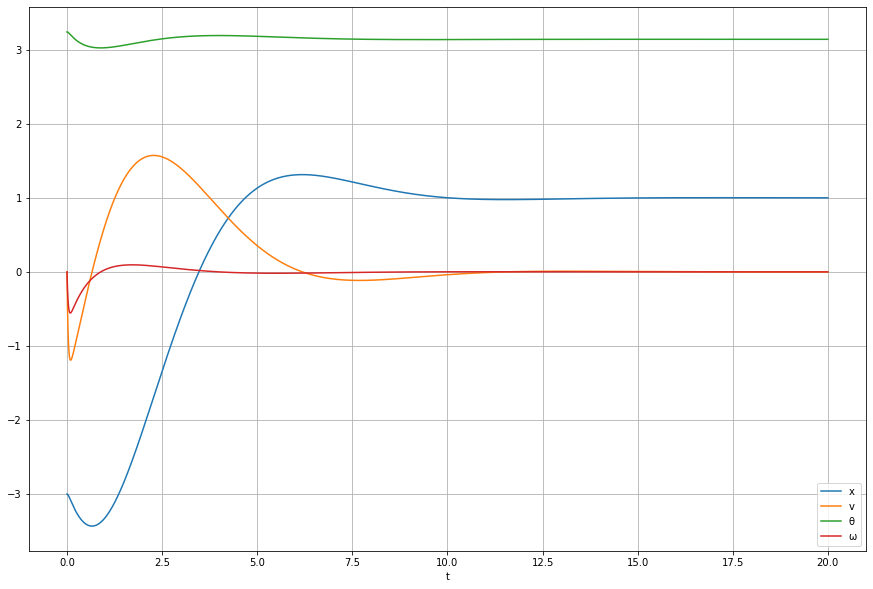

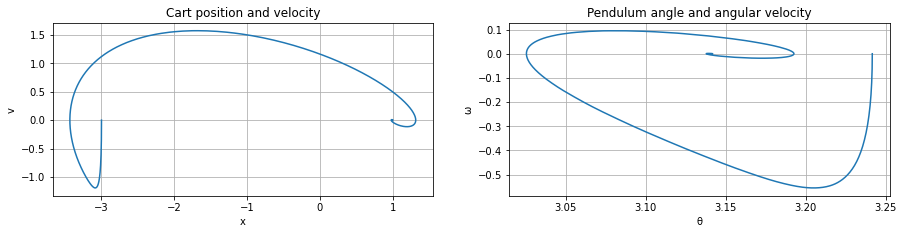

In [23]:
ts_lqr, t_eval_lqr = get_timespan(dt=0.001)

Q = np.diag([1.0, 1.0, 10.0, 100.0])
R = 0.001

K_lqr2, eigs_lqr2, dyn_lqr2 = get_dynamics_for_lqr(par, Q, R)
res_lqr2 = solve_ivp(dyn_lqr2, ts_lqr, Y0_eigs, t_eval=t_eval_lqr)

print(K_lqr2)
print(eigs_lqr2)

simple_plot(res_lqr2.t, res_lqr2.y)
phase_plots(res_lqr2.y)

In [ ]:
sim_animation(res_lqr2.y, par, stride=50)

## Żródła

- [1] S.L. **Brunton**, J.N. **Kutz** (**2019**). *Data-Driven Science and Engineering. Machine Learning, Dynamical Systems, and Control*, Cambridge University Press: Cambridge.

- [2] L.C. **Evans**. *An Introduction to Mathematical Optimal Control Theory Version 0.2*, Lecture notes as downloaded 23.02.2021 from *math.berkeley.edu/~evans/control.course.pdf*. 
    

## Sandbox

Wypróbuj model i potencjalne sterowania z innymi parametrami.